In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
from librosa import display
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile
import os, glob, pickle

!pip install -U librosa resampy
import resampy
from IPython.display import Audio

In [ ]:
Ravdess = "/content/drive/My Drive/ser/audio_speech_actors_01-24/"

In [ ]:
dirl_list = os.listdir(Ravdess)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(Ravdess + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(Ravdess + i + '/' + f)


RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

,count
labels,
male_fear,96
male_angry,96
male_calm,96
male_sad,96
male_happy,96
male_disgust,96
male_surprise,96
female_calm,96
female_happy,96


In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

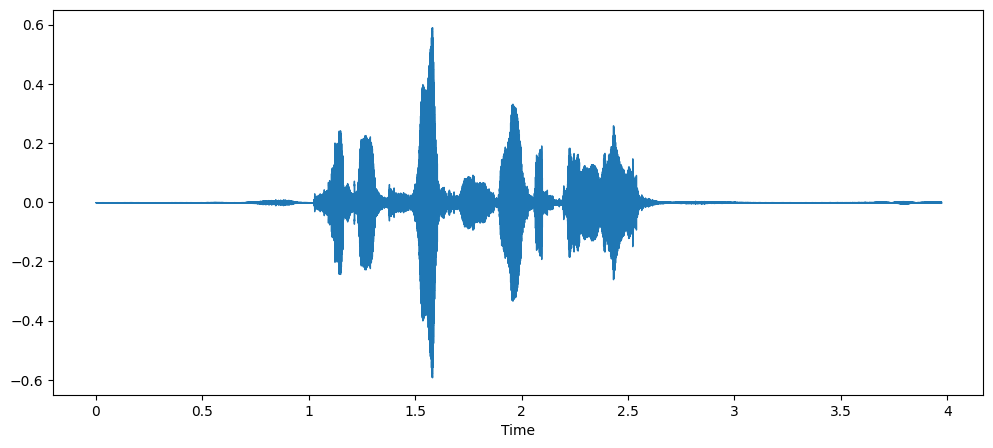

In [ ]:
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

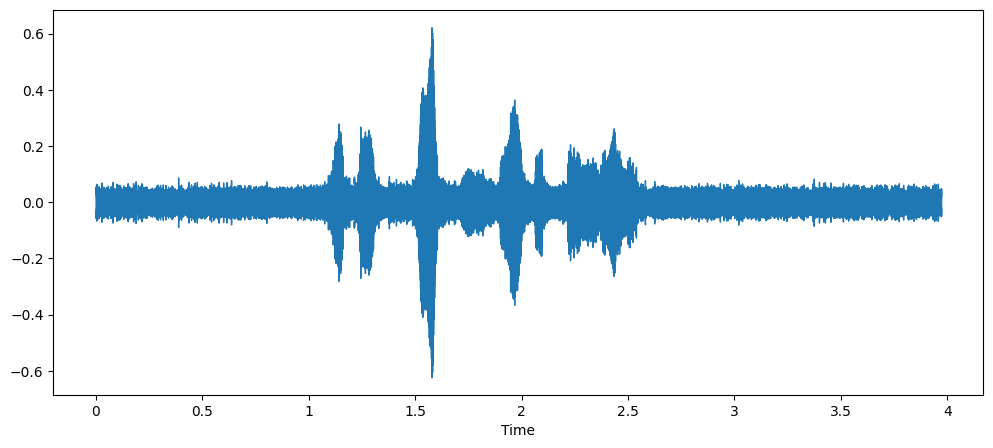

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

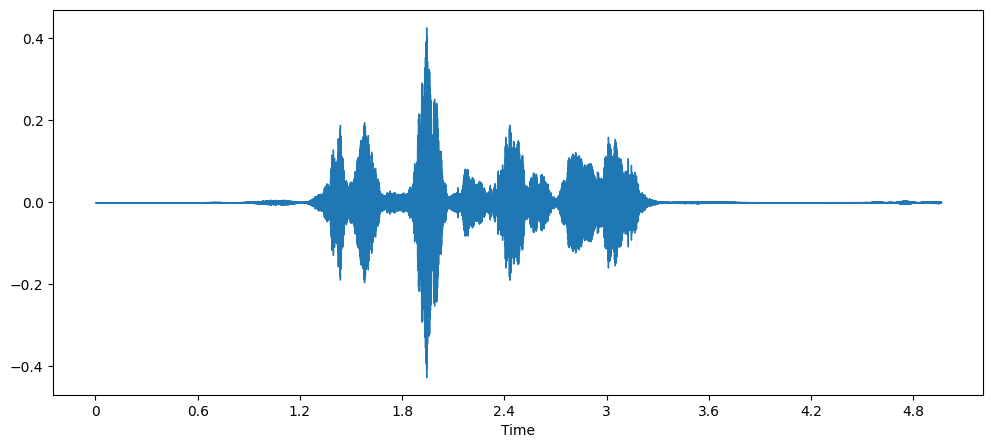

In [ ]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

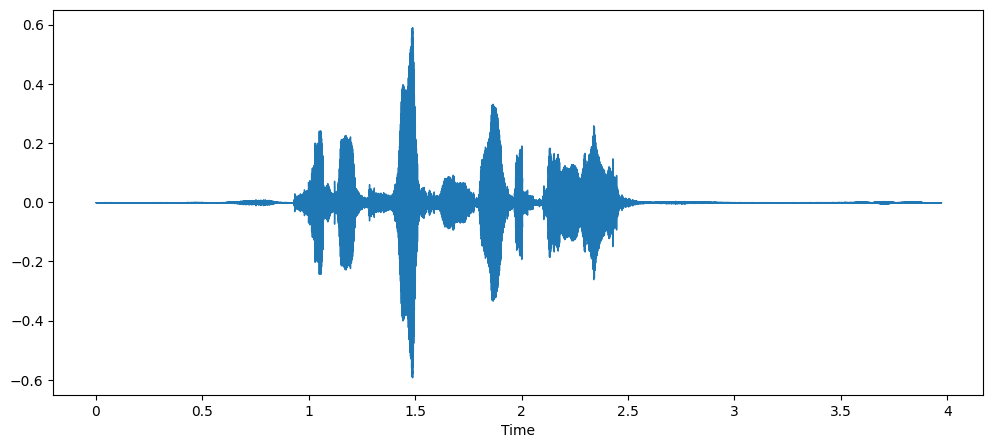

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

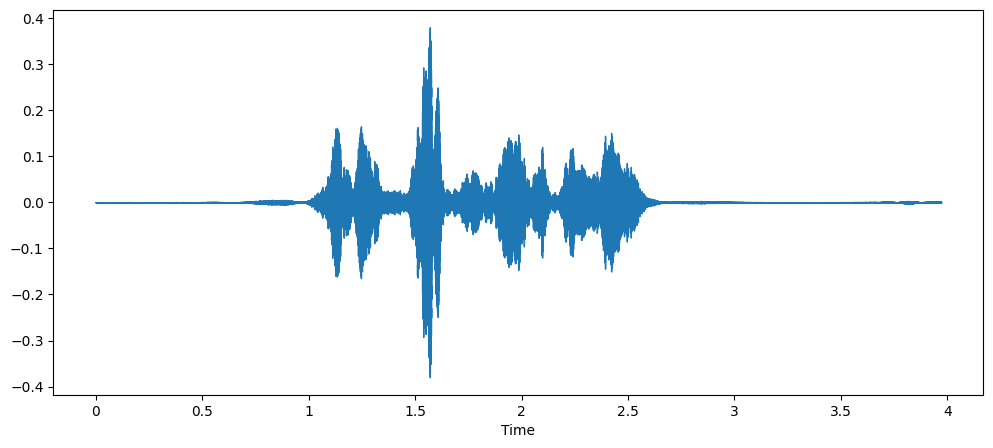

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-512.580872,76.632431,-2.396106,17.774494,10.448370,-4.677785,-6.288651,-12.015334,-18.012011,-3.411375,...,-2.215759,2.634511,-7.890677,-0.261601,4.919361,-8.301306,-4.476529,-2.336499,-3.277639,male_fear
1,-382.460796,40.253328,5.995412,10.105642,4.979121,-3.161016,-4.388007,-10.098643,-12.403079,-7.229529,...,-3.288495,-0.651194,-5.462510,-2.879728,1.102006,-6.936756,-5.564369,-0.573779,-4.274975,male_fear
2,-570.544434,74.445808,-5.101418,17.044762,6.106926,-7.684347,-9.628531,-17.473795,-20.639585,-3.252021,...,0.125599,0.177388,-8.858012,2.195659,0.672794,-12.243671,-4.205153,-3.308533,-7.278893,male_fear
3,-271.813904,38.474594,-27.573185,7.512926,-10.251207,-10.606794,-15.020140,-8.130071,-21.859301,-13.357991,...,-12.867440,-7.040345,-5.118482,-9.251900,-5.545655,-18.138128,-8.973401,-7.473593,-10.404433,male_angry
4,-147.854224,17.394706,-3.661776,1.438605,-1.137335,-4.762393,-3.558765,-1.762895,-6.701111,-5.570550,...,-4.704160,-1.832937,-2.540709,-4.139087,-4.212114,-9.042168,-6.178423,-4.458974,-6.490098,male_angry


In [ ]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-512.580872,76.632431,-2.396106,17.774494,10.448370,-4.677785,-6.288651,-12.015334,-18.012011,-3.411375,...,-2.215759,2.634511,-7.890677,-0.261601,4.919361,-8.301306,-4.476529,-2.336499,-3.277639,male_fear
1,-382.460796,40.253328,5.995412,10.105642,4.979121,-3.161016,-4.388007,-10.098643,-12.403079,-7.229529,...,-3.288495,-0.651194,-5.462510,-2.879728,1.102006,-6.936756,-5.564369,-0.573779,-4.274975,male_fear
2,-570.544434,74.445808,-5.101418,17.044762,6.106926,-7.684347,-9.628531,-17.473795,-20.639585,-3.252021,...,0.125599,0.177388,-8.858012,2.195659,0.672794,-12.243671,-4.205153,-3.308533,-7.278893,male_fear
3,-271.813904,38.474594,-27.573185,7.512926,-10.251207,-10.606794,-15.020140,-8.130071,-21.859301,-13.357991,...,-12.867440,-7.040345,-5.118482,-9.251900,-5.545655,-18.138128,-8.973401,-7.473593,-10.404433,male_angry
4,-147.854224,17.394706,-3.661776,1.438605,-1.137335,-4.762393,-3.558765,-1.762895,-6.701111,-5.570550,...,-4.704160,-1.832937,-2.540709,-4.139087,-4.212114,-9.042168,-6.178423,-4.458974,-6.490098,male_angry


In [ ]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [ ]:
Emotions['labels'] = Emotions['labels'].str.replace('female_', '', regex=False)
Emotions['labels'] = Emotions['labels'].str.replace('male_', '', regex=False)

label_mapping = {
    'angry': 'angry',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'surprise': 'surprise',
    'calm': 'calm'
}
Emotions['labels'] = Emotions['labels'].map(label_mapping)

# Drop rows with missing labels
Emotions = Emotions.dropna(subset=['labels'])
print("Unique labels after mapping:", Emotions['labels'].unique())

Unique labels after mapping: ['fear' 'angry' 'calm' 'neutral' 'sad' 'happy' 'disgust' 'surprise']


In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(Emotions['labels'].values.reshape(-1, 1)).toarray()
print("Shape of Y after encoding:", Y.shape)
print("One-hot categories:", encoder.categories_)

Shape of Y after encoding: (4320, 8)
One-hot categories: [array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)]


In [ ]:
Y.shape

(4320, 7)

In [ ]:
# Train and Test Split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((3456, 20), (3456, 8), (864, 20), (864, 8))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 20), (3456, 8), (864, 20), (864, 8))

In [ ]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3456, 20, 1), (3456, 8), (864, 20, 1), (864, 8))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2

model_mfcc = tf.keras.Sequential()
model_mfcc.add(Conv1D(64, kernel_size=10, activation='relu', input_shape=(20, 1)))
model_mfcc.add(Conv1D(128, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_mfcc.add(MaxPooling1D(pool_size=2))
model_mfcc.add(Dropout(0.4))
model_mfcc.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
model_mfcc.add(GlobalMaxPooling1D())
model_mfcc.add(Dropout(0.4))
model_mfcc.add(Flatten())
model_mfcc.add(Dense(256, activation='relu'))
model_mfcc.add(Dropout(0.4))
model_mfcc.add(Dense(8, activation='sigmoid'))

model_mfcc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mfcc.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 11, 64)              │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 11, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 5, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,768 (428.78 KB)

 Trainable params: 109,768 (428.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_mfcc_history=model_mfcc_history=model_mfcc.fit(x_traincnn, y_train,batch_size=32, epochs=40, validation_data=(x_testcnn, y_test))

Epoch 1/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1620 - loss: 2.6061 - val_accuracy: 0.1644 - val_loss: 2.0947
Epoch 2/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2027 - loss: 2.0543 - val_accuracy: 0.2465 - val_loss: 1.9442
Epoch 3/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2773 - loss: 1.9078 - val_accuracy: 0.3275 - val_loss: 1.8187
Epoch 4/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3166 - loss: 1.8286 - val_accuracy: 0.3762 - val_loss: 1.7563
Epoch 5/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3373 - loss: 1.7761 - val_accuracy: 0.4051 - val_loss: 1.7099
Epoch 6/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3583 - loss: 1.7361 - val_accuracy: 0.3958 - val_loss: 1.6807
Epoch 7/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3522 - loss: 1.7290 - val_accuracy: 0.4074 - val_loss: 1.6614
Epoch 8/40
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3865 - loss: 1.7134 - val_accuracy: 

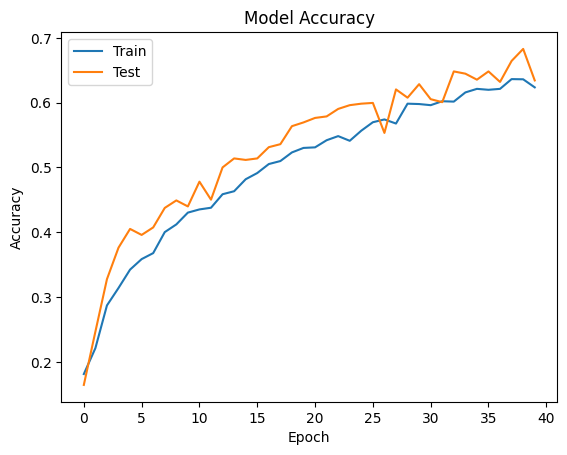

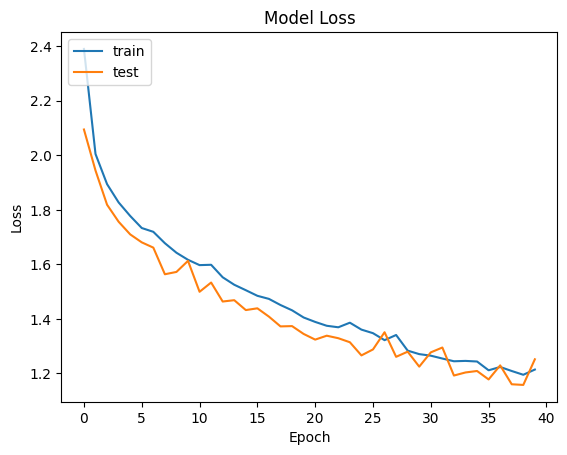

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_mfcc_history.history['accuracy'])
plt.plot(model_mfcc_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_mfcc_history.history['loss'])
plt.plot(model_mfcc_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
model_mfcc2_history=model_mfcc_history=model_mfcc.fit(x_traincnn, y_train,batch_size=32, epochs=50, validation_data=(x_testcnn, y_test))

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6365 - loss: 1.1948 - val_accuracy: 0.6435 - val_loss: 1.1991
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6610 - loss: 1.1515 - val_accuracy: 0.6470 - val_loss: 1.1844
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6579 - loss: 1.1581 - val_accuracy: 0.6655 - val_loss: 1.1557
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6618 - loss: 1.1276 - val_accuracy: 0.6574 - val_loss: 1.2020
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6761 - loss: 1.0962 - val_accuracy: 0.6470 - val_loss: 1.2079
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6653 - loss: 1.1498 - val_accuracy: 0.6655 - val_loss: 1.1621
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6786 - loss: 1.1147 - val_accuracy: 0.6377 - val_loss: 1.2027
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6714 - loss: 1.1228 - val_accuracy

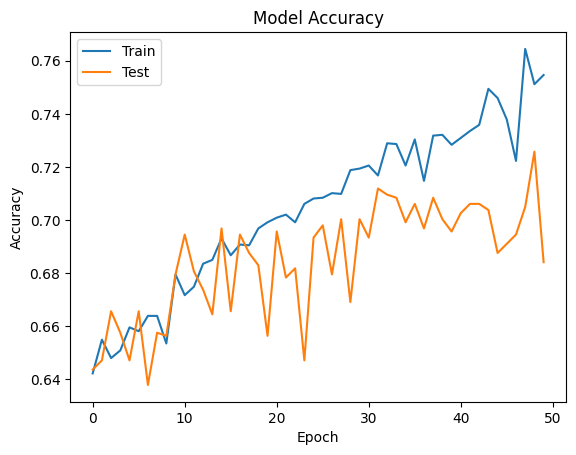

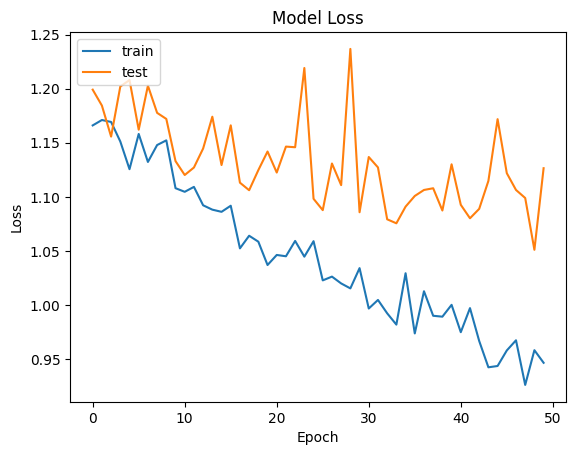

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_mfcc2_history.history['accuracy'])
plt.plot(model_mfcc2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_mfcc2_history.history['loss'])
plt.plot(model_mfcc2_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
print("Loss of the model is - " , model_mfcc.evaluate(x_testcnn,y_test)[0])
print("Accuracy of the model is - " , model_mfcc.evaluate(x_testcnn,y_test)[1]*100 , "%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6861 - loss: 1.1423
Loss of the model is -  1.126491904258728
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6861 - loss: 1.1423
Accuracy of the model is -  68.40277910232544 %


In [ ]:
mfcc_features_array = np.array(mfcc_features)

In [ ]:
## lets make a datagframe containing these features and corresponding emotions
df_features = pd.DataFrame(mfcc_features_array)
## combine both emotion_data and df_features
data = pd.concat([Ravdess_df, df_features], axis=1)
## lets print first 5 rows of new data
data.head()

In [ ]:
data_new = data.drop(columns=['Path'])
data_new.head()

In [ ]:
X = data_new.drop(columns=['Emotions'])
y = data_new['Emotions'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

In [ ]:
print((x_train.shape[0], x_test.shape[0]))

In [ ]:
len(X), len(Y)

(1440, 1440)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,labels
0,-708.799866,48.700954,1.122221,0.025111,-7.621972,-7.224838,-12.110167,-8.403195,-12.154092,-7.848679,...,0.000073,0.000046,0.000053,0.000056,0.000051,0.000021,0.000025,0.000012,7.320705e-07,calm
1,-730.670471,38.349815,2.674319,9.384073,-5.979620,-3.029608,-11.018359,-9.151864,-7.464394,-5.854756,...,0.000036,0.000035,0.000024,0.000024,0.000019,0.000015,0.000011,0.000005,4.307079e-07,calm
2,-490.503113,23.539852,-16.328257,-0.102213,-18.963528,-9.060999,-7.400503,-12.254002,-8.472659,-3.595173,...,0.002068,0.002440,0.002425,0.002488,0.001842,0.001478,0.002046,0.001528,8.736723e-05,angry
3,-509.613251,29.779303,-17.598511,-0.193980,-11.725772,-10.995877,-7.608780,-8.695170,-8.918422,-1.570794,...,0.000739,0.000666,0.001008,0.000852,0.000510,0.000492,0.000634,0.000408,6.137932e-05,angry
4,-676.523376,48.593529,-13.861474,-0.564834,-5.927912,-7.075418,-10.602539,-9.704248,-7.686183,-5.840102,...,0.000021,0.000030,0.000014,0.000017,0.000011,0.000013,0.000010,0.000008,7.473365e-07,happy


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
X.shape, Y.shape

((1440, 180), (1440,))

In [ ]:
Y = Features['labels'].values.reshape(-1, 1)

# Check the shapes
print("X shape:", X.shape)  # (5620, 20) as expected
print("Y shape:", Y.shape)

X shape: (1440, 180)
Y shape: (1440, 1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 180), (1152, 1), (288, 180), (288, 1))

MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
model.fit(X_train,y_train)

TypeError: BaseMultilayerPerceptron.fit() got an unexpected keyword argument 'validation_data'

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 51.04%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.65      0.76        46
        calm       0.49      0.80      0.61        35
     disgust       0.50      0.32      0.39        41
        fear       0.44      0.52      0.48        29
       happy       0.38      0.66      0.48        41
     neutral       0.32      0.39      0.35        18
         sad       1.00      0.12      0.21        43
    surprise       0.55      0.63      0.59        35

    accuracy                           0.51       288
   macro avg       0.57      0.51      0.48       288
weighted avg       0.61      0.51      0.49       288



SVM

In [ ]:
svclassifier = SVC(kernel = 'linear')
svclassifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [ ]:
y_pred = svclassifier.predict(X_test)

              precision    recall  f1-score   support

       angry       0.72      0.67      0.70        46
        calm       0.51      0.74      0.60        35
     disgust       0.46      0.51      0.48        41
        fear       0.46      0.45      0.46        29
       happy       0.55      0.59      0.56        41
     neutral       0.46      0.33      0.39        18
         sad       0.61      0.44      0.51        43
    surprise       0.44      0.40      0.42        35

    accuracy                           0.53       288
   macro avg       0.53      0.52      0.52       288
weighted avg       0.54      0.53      0.53       288

----accuracy score 53.47222222222222 ----


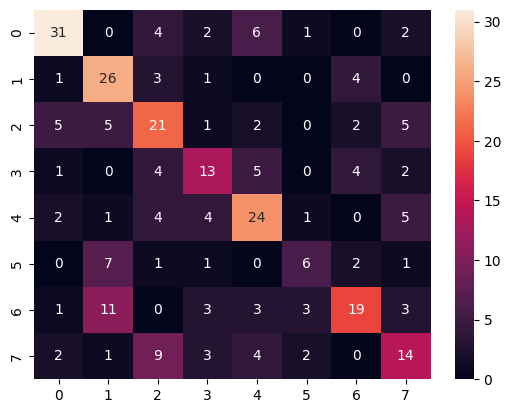

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [ ]:

train_acc = float(svclassifier.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svclassifier.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)


----train accuracy score 76.21527777777779 ----
----test accuracy score 53.47222222222222 ----


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


Shape of y_encoded : (46080, 2)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 20, 1), (1080, 8), (360, 20, 1), (360, 8))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 20, 1, 1), (1080, 8), (360, 20, 1, 1), (360, 8))

CNN

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], 1))  # Shape: (1440, 20, 1)

In [ ]:

# Define the CNN model
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(20, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X, Y)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(32, 8), output.shape=(32, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

model=Sequential()
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 1, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 1, padding = 'same'))

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

NameError: name 'x_train' is not defined

In [ ]:
from keras.callbacks import ReduceLROnPlateau
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.1169 - loss: 7.3202 - val_accuracy: 0.1111 - val_loss: 2.0788 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1234 - loss: 2.1075 - val_accuracy: 0.1139 - val_loss: 2.0782 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1404 - loss: 2.0979 - val_accuracy: 0.1111 - val_loss: 2.0781 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1462 - loss: 2.0881 - val_accuracy: 0.1111 - val_loss: 2.0757 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1568 - loss: 2.0806 - val_accuracy: 0.1111 - val_loss: 2.0773 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1248 - loss: 2.0798 - val_accuracy: 0.1111 - val_loss: 2.0768 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1248 - loss: 2.0690 - val_acc

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3122 - loss: 1.7806
Accuracy of our model on test data :  31.388887763023376 %


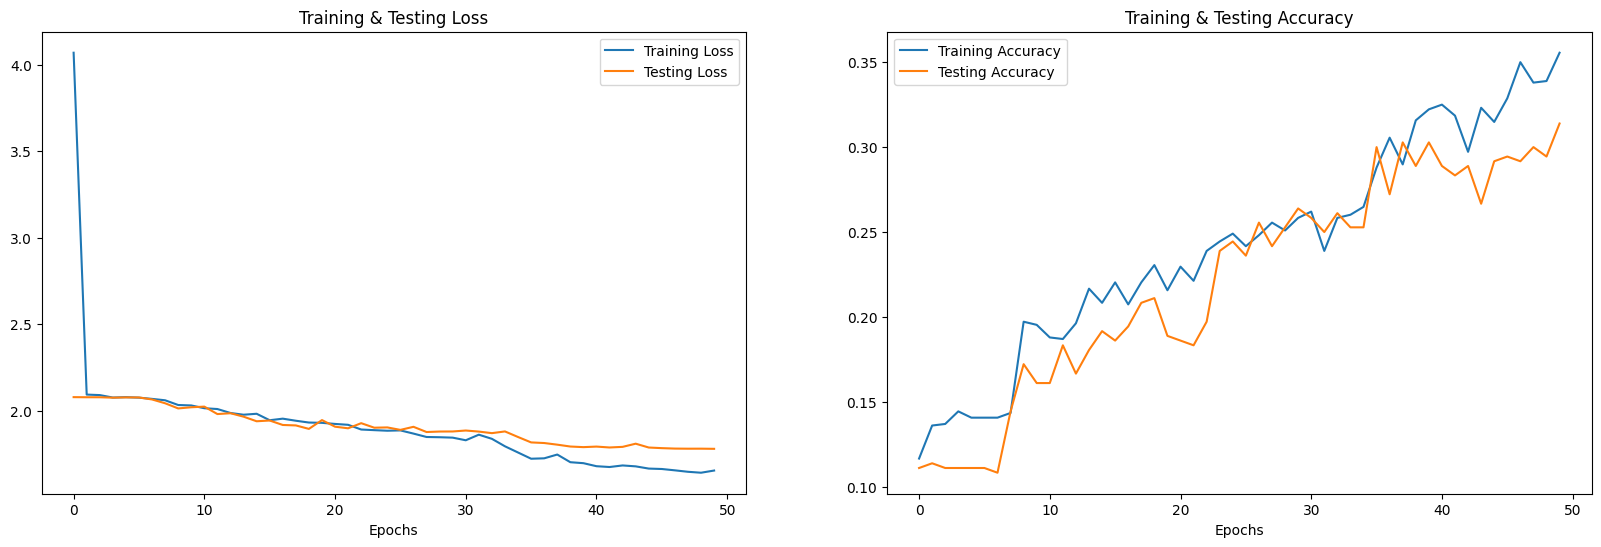

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,calm,calm
1,happy,surprise
2,angry,surprise
3,calm,calm
4,happy,angry
5,calm,neutral
6,calm,happy
7,disgust,disgust
8,angry,angry
9,sad,angry


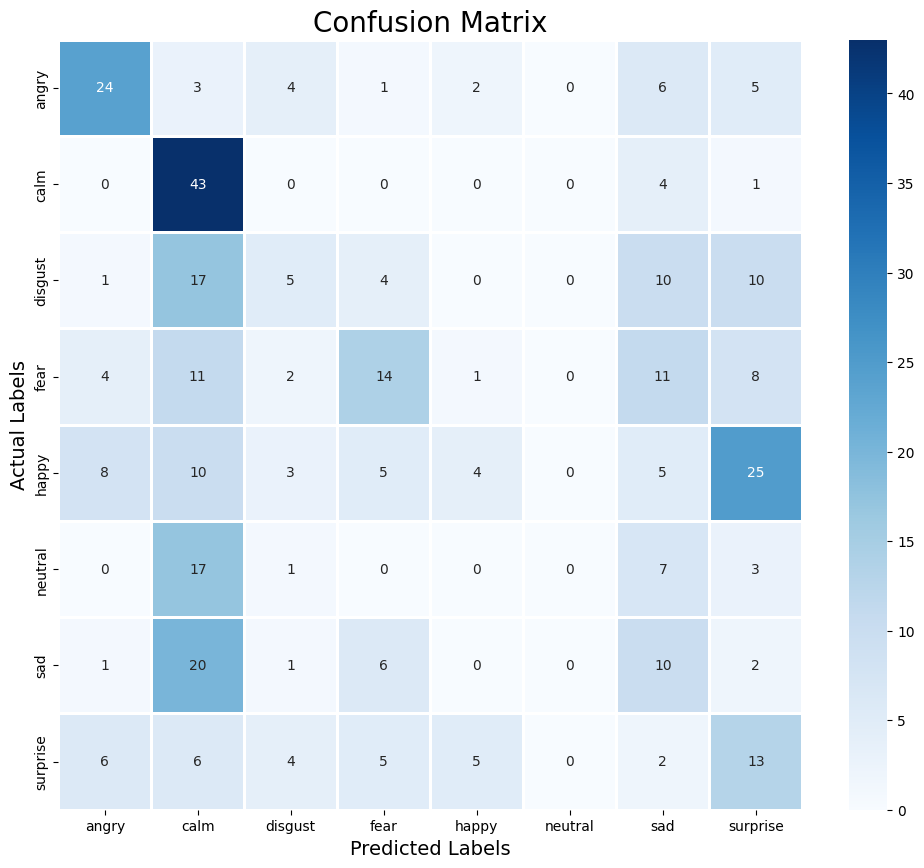

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.55      0.53      0.54        45
        calm       0.34      0.90      0.49        48
     disgust       0.25      0.11      0.15        47
        fear       0.40      0.27      0.33        51
       happy       0.33      0.07      0.11        60
     neutral       0.00      0.00      0.00        28
         sad       0.18      0.25      0.21        40
    surprise       0.19      0.32      0.24        41

    accuracy                           0.31       360
   macro avg       0.28      0.31      0.26       360
weighted avg       0.30      0.31      0.27       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

# First LSTM layer
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.2))

# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output layer for 8 classes
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,464 (654.16 KB)

 Trainable params: 167,464 (654.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.utils import to_categorical
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [ ]:
emotion_mapping = {
    'calm': 0,
    'angry': 1,
    'happy': 2,
    'sad': 3,
    'fear': 4,
    'disgust': 5,
    'surprised': 6,
    'neutral': 7
}

# Convert string labels to integers
y_train = np.array([emotion_mapping[label] for label in y_train])
y_test = np.array([emotion_mapping[label] for label in y_test])

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_test, y_test)
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1304 - loss: 2.0858

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 8)

In [ ]:
mfcc_features = []
for i in range(len(Ravdess_df.Path)):
  data,sr = librosa.load(Ravdess_df.Path[i])
  mfcc_features.append(np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0))

In [ ]:
mfcc_features_array = np.array(mfcc_features)
print(f"Shape of MFCC features : {mfcc_features_array.shape}")

Shape of MFCC features : (1440, 20)


In [ ]:
## lets make a datagframe containing these features and corresponding emotions
df_features = pd.DataFrame(mfcc_features_array)
## combine both emotion_data and df_features
data = pd.concat([Ravdess_df, df_features], axis=1)
## lets print first 5 rows of new data
data.head()

,Emotions,Path,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,calm,/content/drive/My Drive/ser/audio_speech_actor...,-708.799866,48.700954,1.122221,0.025111,-7.621972,-7.224838,-12.110167,-8.403195,...,-6.258116,-3.724779,-8.050489,-4.172003,-3.029605,-7.276315,-4.004338,-3.350937,-4.696883,-5.114195
1,calm,/content/drive/My Drive/ser/audio_speech_actor...,-730.670471,38.349815,2.674319,9.384073,-5.979620,-3.029608,-11.018359,-9.151864,...,-5.191709,-2.519156,-7.551676,-1.783689,-3.010306,-3.162575,-5.148300,-2.132420,-3.725765,-6.272536
2,angry,/content/drive/My Drive/ser/audio_speech_actor...,-490.503113,23.539852,-16.328257,-0.102213,-18.963528,-9.060999,-7.400503,-12.254002,...,-8.703730,3.143956,-6.532009,-6.547723,0.041266,-7.202158,-2.768193,-3.683931,-7.971523,-2.296419
3,angry,/content/drive/My Drive/ser/audio_speech_actor...,-509.613251,29.779303,-17.598511,-0.193980,-11.725772,-10.995877,-7.608780,-8.695170,...,-7.555244,0.288636,-3.093509,-5.366367,-0.200549,-5.725191,-3.759932,-3.531142,-4.722908,-0.877670
4,happy,/content/drive/My Drive/ser/audio_speech_actor...,-676.523376,48.593529,-13.861474,-0.564834,-5.927912,-7.075418,-10.602539,-9.704248,...,-6.994750,-0.827306,-6.848548,-4.461267,-1.393523,-6.919819,-3.178850,-3.801621,-4.759595,-3.153574


In [ ]:
data_new = data.drop(columns=['Path'])
data_new.head()

,Emotions,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,calm,-708.799866,48.700954,1.122221,0.025111,-7.621972,-7.224838,-12.110167,-8.403195,-12.154092,...,-6.258116,-3.724779,-8.050489,-4.172003,-3.029605,-7.276315,-4.004338,-3.350937,-4.696883,-5.114195
1,calm,-730.670471,38.349815,2.674319,9.384073,-5.979620,-3.029608,-11.018359,-9.151864,-7.464394,...,-5.191709,-2.519156,-7.551676,-1.783689,-3.010306,-3.162575,-5.148300,-2.132420,-3.725765,-6.272536
2,angry,-490.503113,23.539852,-16.328257,-0.102213,-18.963528,-9.060999,-7.400503,-12.254002,-8.472659,...,-8.703730,3.143956,-6.532009,-6.547723,0.041266,-7.202158,-2.768193,-3.683931,-7.971523,-2.296419
3,angry,-509.613251,29.779303,-17.598511,-0.193980,-11.725772,-10.995877,-7.608780,-8.695170,-8.918422,...,-7.555244,0.288636,-3.093509,-5.366367,-0.200549,-5.725191,-3.759932,-3.531142,-4.722908,-0.877670
4,happy,-676.523376,48.593529,-13.861474,-0.564834,-5.927912,-7.075418,-10.602539,-9.704248,-7.686183,...,-6.994750,-0.827306,-6.848548,-4.461267,-1.393523,-6.919819,-3.178850,-3.801621,-4.759595,-3.153574


In [ ]:
X = data_new.drop(columns=['Emotions'])
y = data_new['Emotions'].to_numpy()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

## how it is encoded
encoder.get_feature_names_out()

array(['x0_angry', 'x0_calm', 'x0_disgust', 'x0_fear', 'x0_happy',
       'x0_neutral', 'x0_sad', 'x0_surprise'], dtype=object)

In [ ]:
print(f"Shape of y_encoded : {y_encoded.shape}")

Shape of y_encoded : (1440, 8)


In [ ]:
y_encoded = y_encoded.toarray()
y_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=True, random_state=42)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (1152, 20)
Shape of X_test : (288, 20)
Shape of y_train : (1152, 8)
Shape of y_test : (288, 8)


In [ ]:
## scaling features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1152, 20)
(288, 20)


In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense, LSTM

In [ ]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(128, kernel_size=4, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=4, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
## Training
model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
history= model_cnn.fit(X_train, y_train,batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5896 - loss: 1.1890 - val_accuracy: 0.5035 - val_loss: 1.3149
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5556 - loss: 1.2091 - val_accuracy: 0.5035 - val_loss: 1.3038
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5626 - loss: 1.2192 - val_accuracy: 0.4965 - val_loss: 1.3361
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5907 - loss: 1.1515 - val_accuracy: 0.4861 - val_loss: 1.2976
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5928 - loss: 1.1451 - val_accuracy: 0.5069 - val_loss: 1.3054
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5786 - loss: 1.1802 - val_accuracy: 0.5382 - val_loss: 1.2891
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5806 - loss: 1.1860 - val_accuracy: 0.5451 - val_loss: 1.2962
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6060 - loss: 1.1139 - val_accuracy: 0.5208 - 

In [ ]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 17, 64)              │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 14, 128)             │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 4, 128)              │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,240 (653.28 KB)

 Trainable params: 166,984 (652.28 KB)

 Non-trainable params: 256 (1.00 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5694 - loss: 1.1668
Accuracy of our model on test data :  61.11111044883728 %


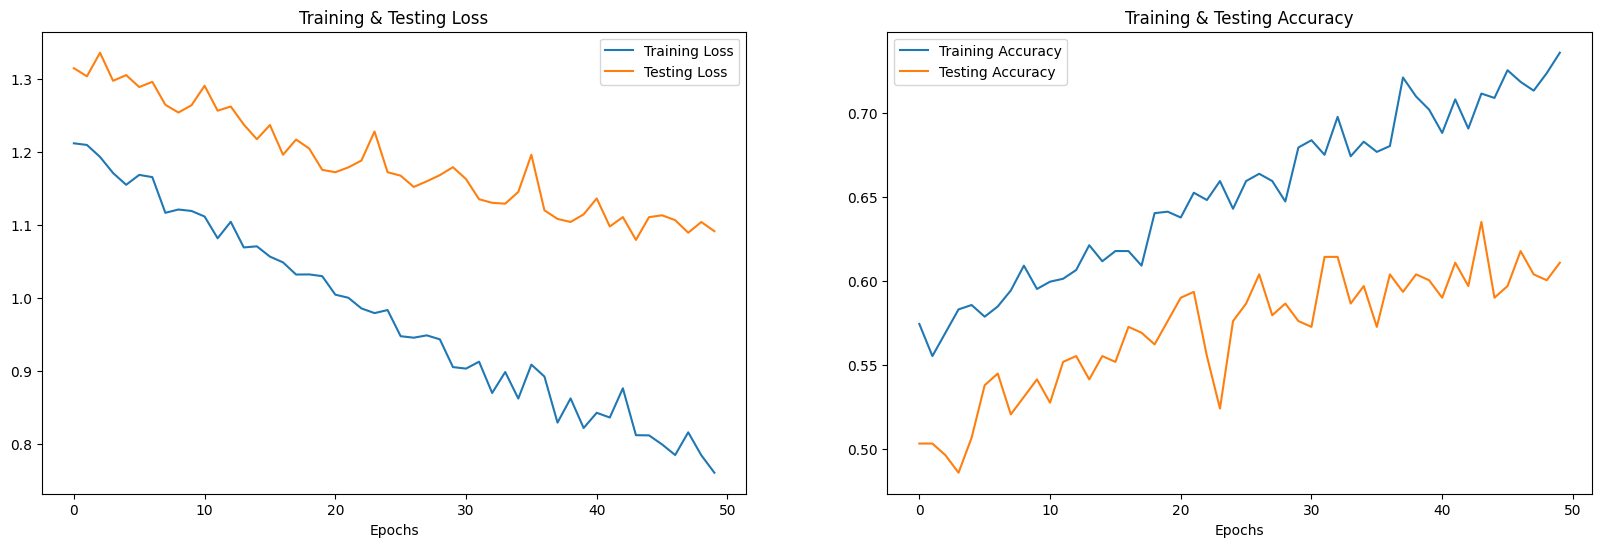

In [ ]:
print("Accuracy of our model on test data : " , model_cnn.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
history= model_cnn.fit(X_train, y_train,batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7145 - loss: 0.7918 - val_accuracy: 0.6111 - val_loss: 1.0801
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7284 - loss: 0.7552 - val_accuracy: 0.6042 - val_loss: 1.0678
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6955 - loss: 0.8283 - val_accuracy: 0.6181 - val_loss: 1.0636
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7611 - loss: 0.7305 - val_accuracy: 0.5903 - val_loss: 1.1233
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7165 - loss: 0.7476 - val_accuracy: 0.6111 - val_loss: 1.0663
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7472 - loss: 0.7018 - val_accuracy: 0.5972 - val_loss: 1.1035
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7337 - loss: 0.7784 - val_accuracy: 0.6076 - val_loss: 1.0761
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7518 - loss: 0.6926 - val_accuracy: 0.6111 - val

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6049 - loss: 1.1645  
Accuracy of our model on test data :  65.97222089767456 %


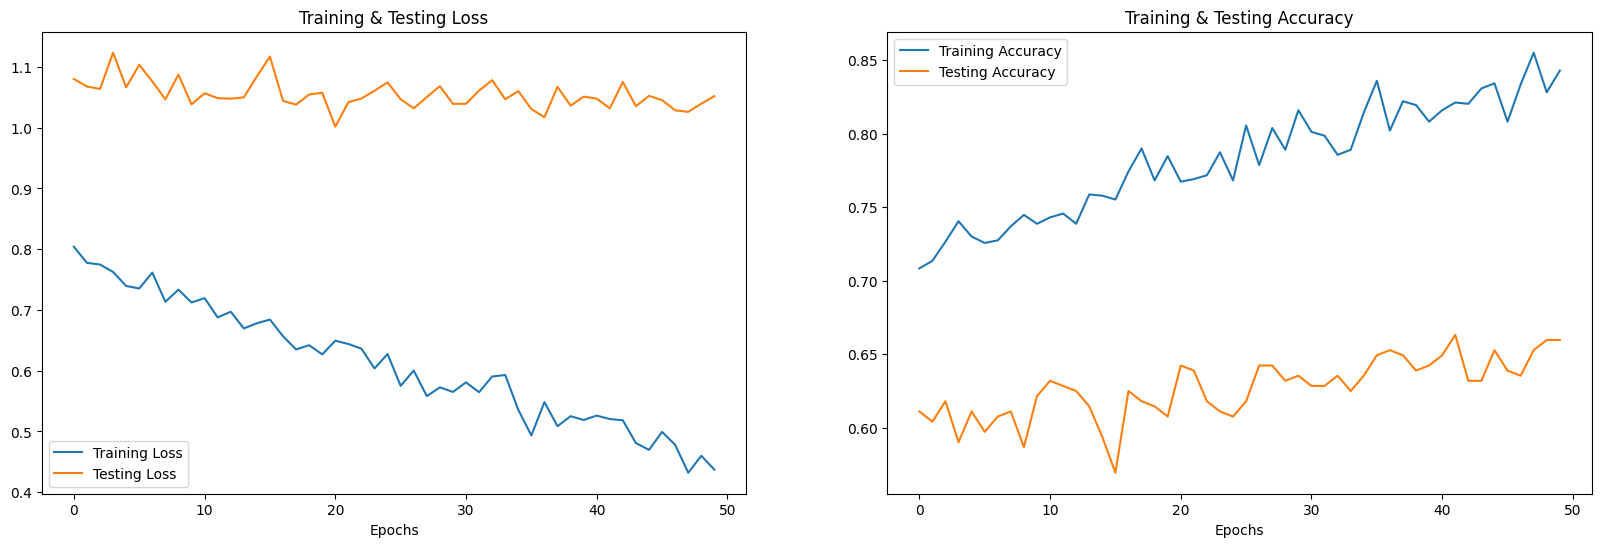

In [ ]:
print("Accuracy of our model on test data : " , model_cnn.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
model_cnn.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[lr_schedule])


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8569 - loss: 0.4061 - val_accuracy: 0.6597 - val_loss: 1.0455 - learning_rate: 1.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8448 - loss: 0.4325 - val_accuracy: 0.6458 - val_loss: 1.0046 - learning_rate: 1.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8534 - loss: 0.4064 - val_accuracy: 0.6493 - val_loss: 1.0225 - learning_rate: 1.0000e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8740 - loss: 0.3809 - val_accuracy: 0.6458 - val_loss: 1.0306 - learning_rate: 1.0000e-04
Epoch 5/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8519 - loss: 0.4032
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8528 - loss: 0.4020 - val_accuracy: 0.6354 - val_loss: 1.0303 - learning_rate: 1.0000e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8688 - los